In [1]:
from __init__ import *
from natsort import natsorted
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import itertools
import scipy.cluster.hierarchy as sch


import snmcseq_utils
import importlib
importlib.reload(snmcseq_utils)

<module 'snmcseq_utils' from '/cndd/fangming/snmcseq_dev/snmcseq_utils.py'>

In [2]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc

def gene_name_to_id(gene_name, df_genes_v2):
    """df_genes
    """
#     df = df_genes.reset_index().groupby('gene_name').first()
    try:
        return df_genes_v2.loc[gene_name, 'gene_id'] 
    except:
        return None

In [3]:
ens = 'Ens0'
cluster_type = 'mCH_npc50_k30_merged'
files = natsorted(glob.glob(os.path.join(PATH_ENSEMBLES, ens, 'allc_merged', cluster_type, 
                                         'allc_merged_mCG_{}_*_{}_mergestrands.tsv'.format(cluster_type, ens)))) 

f = os.path.join(PATH_ENSEMBLES, ens, '{}.tsv'.format(ens))
df_info = pd.read_table(f, index_col='cell_name')

f = os.path.join(PATH_ENSEMBLES, ens, 'tsne', 'tsne_perp30_binc_mCHmCG_human_combined_100000_summary_nmcc_v3.tsv')
df_tsne = pd.read_table(f, index_col='sample')
df_info = pd.merge(df_info, df_tsne, left_index=True, right_index=True)

f = os.path.join(PATH_ENSEMBLES, ens, 'mapping_summary_{}.tsv'.format(ens))
df_meta = pd.read_table(f, index_col='Sample')
df_info = pd.merge(df_info, df_meta, left_index=True, right_index=True)

df_info.head()

,dataset,cluster,annotation,tsne_x,tsne_y,Library pool,Layer,Total reads,Mapped reads,Mapping rate,...,Nonclonal rates,Lambda mC/C,mCCC/CCC,mCG/CG,mCH/CH,Estimated mCG/CG,Estimated mCH/CH,% Genome covered,Biosample,allc file location (Mukamel lab)
160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed,MB_v1,8,hSst-2,4.023829,50.359272,K1K2,NaN,6947874.0,3881291.0,55.90%,...,50.70%,NaN,0.00772,0.81781,0.03853,0.81639,0.03105,6.94,MB_v1,NaN
160729_MB_v1_hs_25yr_MFG_pool_1019_AD006_indexed,MB_v1,8,hSst-2,-24.774567,89.472031,L1L2,NaN,8849490.0,5049795.0,57.10%,...,42.80%,NaN,0.01195,0.83620,0.06393,0.83422,0.05261,7.19,MB_v1,NaN
160729_MB_v1_hs_25yr_MFG_pool_101_AD010_indexed,MB_v1,8,hSst-2,-11.439241,80.250549,20160729_B1B2,NaN,4441591.0,2283700.0,51.40%,...,60.30%,NaN,0.01352,0.83509,0.07130,0.83283,0.05857,4.70,MB_v1,NaN
160729_MB_v1_hs_25yr_MFG_pool_1022_AD006_indexed,MB_v1,8,hSst-2,3.210637,48.236778,L1L2,NaN,7943555.0,4719450.0,59.40%,...,45.80%,NaN,0.00735,0.82081,0.03745,0.81948,0.03032,7.20,MB_v1,NaN
160729_MB_v1_hs_25yr_MFG_pool_1033_AD002_indexed,MB_v1,8,hSst-2,-21.555132,89.407265,L1L2,NaN,3505965.0,1842072.0,52.50%,...,54.60%,NaN,0.00890,0.83048,0.04493,0.82896,0.03635,3.51,MB_v1,NaN


In [ ]:
df_annot = df_info.drop(['dataset', 'tsne_x', 'tsne_y'], axis=1).groupby('cluster').first().fillna('Glia/unlabeled')
df_annot_2 = df_info[['dataset', 'cluster']].groupby('cluster').count().rename(columns={'dataset': 'num'})
df_annot = pd.merge(df_annot, df_annot_2, left_index=True, right_index=True) 
df_annot.head()

f = os.path.join(PATH_REFERENCES, 'Annotation', 'gencode.v19.annotation_genes.tsv')
df_genes = pd.read_table(f, index_col='gene_id')
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
df_genes.head()

In [12]:
allc_fs = []
for f in files:
    allc_f = pd.read_table(f, header=None, names=['chr', 'pos', 'strand', 'context', 'mc', 'c', 'methylation'], iterator=True)
    allc_fs.append(allc_f)

In [13]:
covs = []
size = 1000000
for allc_f in allc_fs:
    df = allc_f.get_chunk(size)
    covs.append(df['c'].sum()/size)


/cndd/fangming/venvs/venv_dobro_snmcseq/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


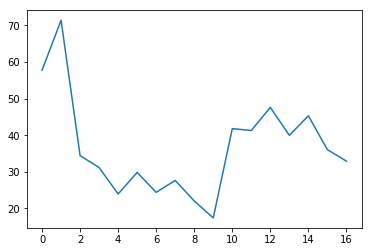

In [14]:
num_cells = df_info.groupby('cluster').count()['dataset'].values

fig, ax = plt.subplots()
ax.plot(covs)
        #/np.sum(covs), label='frac coverage')
# ax.plot(num_cells, label='frac num_cells')
ax.legend()
plt.show()

In [ ]:
snmcseq_utils.plot_tsne_labels(df_info, tc='cluster')
snmcseq_utils.plot_tsne_labels(df_info, tc='annotation')

In [ ]:
f = os.path.join(PATH_ENSEMBLES, ens, 'gene_level', 'genebody_mCH_human_combined_summary.tsv')
df_input = pd.read_table(f, index_col='id')

In [ ]:
df_input.head()

In [ ]:
df_mcc_cells = get_mcc(df_input, sufficient_coverage_fraction=0.9)
df_mcc_cells.head()

In [ ]:
# cluster mc_c
df_c = df_input.filter(regex='_c$')
df_mc = df_input.filter(regex='_mc$')

df_mc_c = pd.DataFrame() 
for label, df_sub in df_info.groupby('cluster'):
    samples = df_sub.index.values
    df_mc_c['{}_mc'.format(label)] = df_mc[samples+'_mc'].sum(axis=1)
    df_mc_c['{}_c'.format(label)] = df_c[samples+'_c'].sum(axis=1)


In [ ]:
df_mc_c.head()

In [ ]:
# df_mcc = get_mcc(df_mc_c)
print(df_mcc.shape)
df_mcc.head()

In [ ]:
# cooked

In [ ]:
# dendrogram 
drop_cols = ["{}_mcc".format(i) for i in [30, 31, 32]]

Z = sch.linkage(df_mcc.drop(drop_cols, axis=1).rank(pct=True, axis=0).T, method='average', metric='correlation')
fig, ax = plt.subplots(figsize=(6, 12))
sch.dendrogram(Z, ax=ax, orientation='left')
ax.set_yticklabels(
    ['C{} ({} {})'.format(int(label.get_text())+1, 
                       df_annot.loc[int(label.get_text())+1, 'annotation'], 
                       df_annot.loc[int(label.get_text())+1, 'num'], 
                      )
     for label in ax.get_yticklabels()], 
    fontsize=12)
ax.set_xlabel('Metric: Spearman correlation of mCH level', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

In [ ]:
# remove C32 C31 C30

# merge C29 C5

# merge C19 8

# merge C21 27 28 13

# 20 18 23

# 7 17

# 16 22 24 10 

# 

In [ ]:
# and how shall we merge
# df_annot.head()

df_plot = df_info.copy()
df_plot['cluster'] = df_plot['cluster'].apply(lambda x: x if x in [1, 2, 3] else np.nan)
snmcseq_utils.plot_tsne_labels(df_plot, tc='cluster')

gene_name = 'Pvalb'.upper()
gene_id = gene_name_to_id(gene_name, df_genes_v2)
df_gene = df_mcc_cells.loc[gene_id, :]
df_gene.index = map(lambda x: x[:-len('_mcc')], df_gene.index.values)
df_gene = df_gene.divide(df_info['mCH/CH'])

df_plot = pd.merge(df_info, df_gene.to_frame(gene_name), left_index=True, right_index=True)
snmcseq_utils.plot_tsne_values(df_plot, tc=gene_name)

In [ ]:
# number 
fig, ax = plt.subplots(figsize=(8, 6))
nums = df_annot['num'].values
df_plot = pd.Series(nums).to_frame('num').reset_index()
df_plot['index'] += 1
sns.barplot(x='index', y='num', data=df_plot, color='C1')
plt.show()

In [ ]:
# drops = [30, 31, 32]
nums = df_annot['num'].tolist()
for i in drops:
    nums[i-1] = np.nan

lsts = [[5, 29], 
       [19, 8], 
       [21, 27, 28, 13], 
        [20, 18, 23],
        [7, 17],
        [16, 22, 24],
        [12, 25, 26],
       ]

for lst in lsts:
    tmp = 0
    for i in lst:
        tmp += nums[i-1] 
        nums[i-1] = np.nan 
    nums.append(tmp)
    

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

df_plot = pd.Series(nums).to_frame('num').reset_index()
df_plot['index'] += 1

sns.barplot(x='index', y='num', data=df_plot, color='C1')
plt.show()

In [ ]:
# new cell cluster list

def old_to_new_cluster(cluster_id, dic):
    """cluster_id is an integer
    """
    try:
        return dic[cluster_id]
    except:
        return cluster_id
    
dic = {5: 33, 
      29: 33,
      19: 34,
      8: 34,
      21: 35,
      27: 35,
      28: 35,
      13: 35,
      20: 36,
      18: 36,
      23: 36,
       7: 37,
      17: 37,
      16: 38,
      22: 38,
      24: 38,
       12: 39,
       25: 39,
       26: 39,
       30: 0,
       31: 0,
       32: 0,
      } 

In [ ]:
df_info_new1 = df_info[['dataset', 'cluster', 'annotation', 'tsne_x', 'tsne_y']].copy()
df_info_new1['cluster'] = df_info_new1['cluster'].apply(lambda x: old_to_new_cluster(x, dic))
df_info_new1 = df_info_new1[~(df_info_new1['cluster']==0)] #drop cluster 0

print(df_info_new1.shape)
df_info_new1.head()
df_info_new1.reset_index().rename(columns={'index': 'cell_name'}).to_csv(
    os.path.join(PATH_ENSEMBLES, ens, 'output/{}_merged.tsv'.format(ens)), 
                    sep='\t', na_rep='NA', header=True, index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

nums = df_info_new1.groupby('cluster').count().iloc[:, 0]
df_plot = pd.Series(nums).to_frame('num').reset_index()
sns.barplot(x='cluster', y='num', data=df_plot, color='C1')
plt.show()

nums

In [ ]:
n = 195

lst = []
for cluster, df_sub in df_info_new1.groupby('cluster'):
    lst.append(df_sub.sample(n))
    
df_info_new2 = pd.concat(lst)
print(df_info_new2.shape)
df_info_new2.head()
df_info_new2.reset_index().rename(columns={'index': 'cell_name'}).to_csv(
    os.path.join(PATH_ENSEMBLES, ens, 'output/{}_merged_subsampled.tsv'.format(ens)), 
                    sep='\t', na_rep='NA', header=True, index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

nums = df_info_new2.groupby('cluster').count().iloc[:, 0]
df_plot = pd.Series(nums).to_frame('num').reset_index()
sns.barplot(x='cluster', y='num', data=df_plot, color='C1')
plt.show()

nums

In [85]:
# get info from 'Ens0'

ens = 'Ens0'
f = os.path.join(PATH_ENSEMBLES, ens, '{}_merged.tsv'.format(ens))
fout = os.path.join(PATH_ENSEMBLES, ens, '{}_merged.pdf'.format(ens))
df_info = pd.read_table(f, index_col='cell_name') 


In [86]:
df_annot = df_info.groupby('cluster').first()
df_annot['annotation'] = df_annot['annotation'].apply(lambda x: x[:len('Glia')] if x.startswith('Glia') else x)

In [87]:
df_info_c = df_info.copy()
df_info_c['cluster'] = df_info_c['cluster'].apply(lambda x: '{} (C{})'.format(df_annot.loc[x, 'annotation'], x))

Saved to /cndd/Public_Datasets/human_snmcseq/Ensembles/Ens0/Ens0_merged.pdf


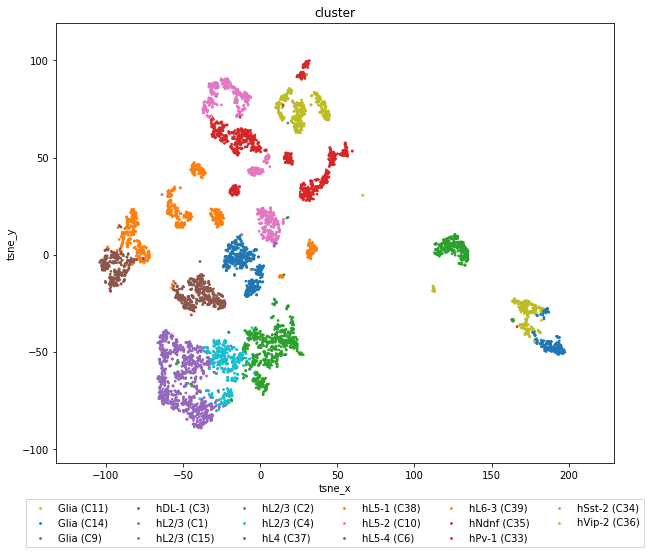

In [88]:
plot_tsne_labels(df_info_c, tc='cluster', legend_mode=1, figsize=(10, 9), s=3, output=fout)

Saved to /cndd/Public_Datasets/human_snmcseq/Ensembles/Ens0/Ens0_merged.pdf


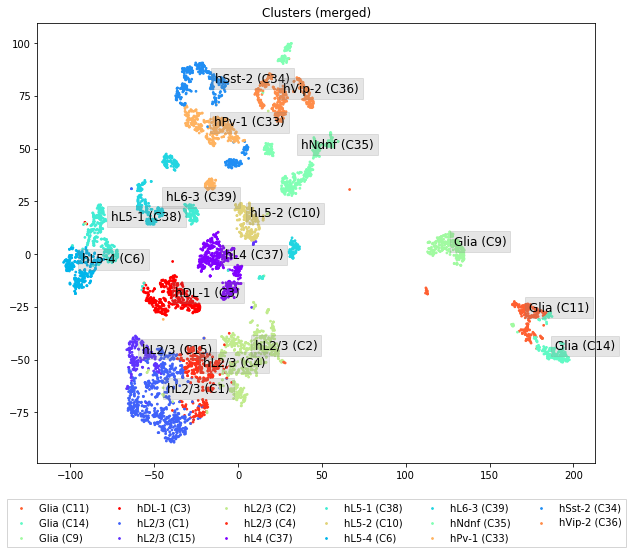

In [90]:
output = fout
centroids = df_info_c.groupby('cluster').quantile(0.6)
nclusters = centroids.shape[0]
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, nclusters))

fig, ax = plt.subplots(figsize=(10, 9))
snmcseq_utils.myScatter(ax, df_info_c, 'tsne_x', 'tsne_y', 'cluster',
         s=3,
         grey_label='unlabeled',
         random_state=1, 
         legend_mode=1, 
         colors=colors
                       )
ax.set_title('Clusters (merged)')
for cluster, row in centroids.iterrows():
    t = ax.annotate(cluster, (row['tsne_x'], row['tsne_y']), fontsize=12)
    t.set_bbox(dict(facecolor='C7', alpha=0.2, edgecolor='C7'))

if output:
    fig.savefig(output)
    print('Saved to ' + output) 

In [39]:
def plot_tsne_labels(df, tx='tsne_x', ty='tsne_y', tc='cluster_ID', 
                    grey_label='unlabeled',
                    legend_mode=0,
                    s=1,
                    random_state=None,
                    output=None, show=True, close=False, 
                    t_xlim='auto', t_ylim='auto', title=None, figsize=(8,6),
                    legend_loc='lower right',
                    colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C8', 'C9'], **kwargs):
    """
    tSNE plot

    xlim, ylim is set to facilitate displaying glial clusters only

    # avoid gray-like 'C7' in colors
    # color orders are arranged for exci-inhi-glia plot 11/1/2017
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    fig, ax = plt.subplots(figsize=figsize)

    snmcseq_utils.myScatter(ax, df, tx, ty, tc,
             s=s,
             grey_label=grey_label,
             random_state=random_state, 
             legend_mode=legend_mode, 
             colors=colors, **kwargs)

    if title:
        ax.set_title(title)
    else:
        ax.set_title(tc)
    ax.set_xlabel(tx)
    ax.set_ylabel(ty)
    ax.set_aspect('auto')

    if t_xlim == 'auto':
        t_xlim = [np.nanpercentile(df[tx].values, 0.1), np.nanpercentile(df[tx].values, 99.9)]
        t_xlim[0] = t_xlim[0] - 0.1*(t_xlim[1] - t_xlim[0])
        t_xlim[1] = t_xlim[1] + 0.1*(t_xlim[1] - t_xlim[0])
        ax.set_xlim(t_xlim)
    elif t_xlim:
        ax.set_xlim(t_xlim)
    else:
        pass  

    if t_ylim == 'auto':
        t_ylim = [np.nanpercentile(df[ty].values, 0.1), np.nanpercentile(df[ty].values, 99.9)]
        t_ylim[0] = t_ylim[0] - 0.1*(t_ylim[1] - t_ylim[0])
        t_ylim[1] = t_ylim[1] + 0.1*(t_ylim[1] - t_ylim[0])
        ax.set_ylim(t_ylim)
    elif t_ylim:
        ax.set_ylim(t_ylim)
    else:
        pass

    if output:
        fig.savefig(output)
        print('Saved to ' + output) 
    if show:
        plt.show()
    if close:
        plt.close(fig)
